# **Classification du churn dans une entreprise de service numérique**

L'objectif est de prédire la résiliation des clients d'une entreprise de services téléphoniques et Internet à l'aide d'un modèle de Machine Learning.

- `CustomerID` : Un identifiant unique pour chaque client.
- `Zip Code` : Le code postal de la résidence principale du client.
- `Gender` : Le genre du client : Masculin, Féminin.
- `Senior Citizen` : Indique si le client a 65 ans ou plus : Oui, Non.
- `Partner` : Indique si le client a un partenaire : Oui, Non.
- `Dependents` : Indique si le client vit avec des personnes à charge : Oui, Non. Les personnes à charge peuvent être des enfants, parents, grands-parents, etc.
- `Tenure Months` : Indique le nombre total de mois que le client a passé avec l'entreprise à la fin du trimestre d'étude.
- `Phone Service` : Indique si le client est abonné à un service de téléphone à domicile avec l'entreprise : Oui, Non.
- `Multiple Lines` : Indique si le client est abonné à plusieurs lignes téléphoniques avec l'entreprise : Oui, Non.
- `Internet Service` : Indique si le client est abonné à un service Internet avec l'entreprise : Non, DSL, Fibre optique.
- `Online Security` : Indique si le client est abonné à un service supplémentaire de sécurité en ligne fourni par l'entreprise : Oui, Non.
- `Online Backup` : Indique si le client est abonné à un service supplémentaire de sauvegarde en ligne fourni par l'entreprise : Oui, Non.
- `Device Protection` : Indique si le client est abonné à un plan de protection supplémentaire pour son équipement Internet fourni par l'entreprise : Oui, Non.
- `Tech Support` : Indique si le client est abonné à un plan de support technique supplémentaire avec des temps d'attente réduits : Oui, Non.
- `Streaming TV` : Indique si le client utilise son service Internet pour diffuser des programmes télévisés via un fournisseur tiers : Oui, Non. L'entreprise ne facture pas de frais supplémentaires pour ce service.
- `Streaming Movies` : Indique si le client utilise son service Internet pour diffuser des films via un fournisseur tiers : Oui, Non. L'entreprise ne facture pas de frais supplémentaires pour ce service.
- `Contract` : Indique le type de contrat actuel du client : Mois par Mois, Un an, Deux ans.
- `Paperless Billing` : Indique si le client a opté pour la facturation sans papier : Oui, Non.
- `Payment Method` : Indique comment le client paye sa facture : Prélèvement bancaire, Carte de crédit, Chèque envoyé par courrier, Chèque automatique.
- `Monthly Charge` : Indique le montant total actuel mensuel des services de l'entreprise pour le client.
- `Total Charges` : Indique les frais totaux du client, calculés jusqu'à la fin du trimestre spécifié ci-dessus.
- `CLTV` : Valeur vie client (Customer Lifetime Value). Une CLTV prédite est calculée à l'aide de formules d'entreprise et de données existantes. Plus la valeur est élevée, plus le client est précieux. Les clients de grande valeur doivent être surveillés pour éviter leur départ.
- `Churn Value` : 1 = le client a quitté l'entreprise ce trimestre. 0 = le client est resté avec l'entreprise. Ceci est la variable à prédire.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")

### **0. Vision d'ensemble**

In [2]:
df = pd.read_csv("DatasetChurn.csv")
df.head()

,CustomerID,Zip Code,Lat Long,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,...,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value,CLTV
0,9638-JIQYA,95303,"37.4695, -120.672724",Male,No,No,No,2,No,No phone service,...,No,No,No,Month-to-month,Yes,Credit card (automatic),24.90,49.70,0,4033
1,2892-GESUL,92675,"33.521447, -117.602555",Female,No,Yes,Yes,18,Yes,No,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.35,309.25,0,2269
2,3808-HFKDE,91801,"34.090925, -118.128164",Female,No,No,No,20,Yes,No,...,No,No,No,Month-to-month,Yes,Electronic check,44.35,927.15,0,3460
3,0278-YXOOG,90301,"33.956445, -118.358634",Male,No,No,No,5,Yes,No,...,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,21.05,113.85,1,2604
4,4869-EPIUS,94901,"37.972662, -122.491452",Male,No,Yes,No,56,Yes,No,...,No,No,Yes,One year,Yes,Electronic check,80.90,4557.50,0,5344


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6174 entries, 0 to 6173
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         6174 non-null   object 
 1   Zip Code           6174 non-null   int64  
 2   Lat Long           6174 non-null   object 
 3   Gender             6174 non-null   object 
 4   Senior Citizen     6174 non-null   object 
 5   Partner            6165 non-null   object 
 6   Dependents         6174 non-null   object 
 7   Tenure Months      6174 non-null   int64  
 8   Phone Service      6174 non-null   object 
 9   Multiple Lines     6174 non-null   object 
 10  Internet Service   6174 non-null   object 
 11  Online Security    6174 non-null   object 
 12  Online Backup      6174 non-null   object 
 13  Device Protection  6174 non-null   object 
 14  Tech Support       6174 non-null   object 
 15  Streaming TV       6174 non-null   object 
 16  Streaming Movies   6158 

In [4]:
df.nunique()

CustomerID           6174
Zip Code             1652
Lat Long             1652
Gender                  2
Senior Citizen          2
Partner                 2
Dependents              2
Tenure Months          73
Phone Service           2
Multiple Lines          3
Internet Service        3
Online Security         3
Online Backup           3
Device Protection       3
Tech Support            3
Streaming TV            3
Streaming Movies        3
Contract                3
Paperless Billing       2
Payment Method          4
Monthly Charges      1523
Total Charges        5827
Churn Value             2
CLTV                 3243
dtype: int64

- Les colonnes `Zip Code` et `Lat Long` ont le même nombre de valeurs uniques.
- Y'aurait-il une correspondance entre ces deux colonnes ?

In [5]:
# Confirmons l'association entre un Zip Code et des coordonnées géographiques
(
    df.groupby("Zip Code")  # pour chaque Zip Code
    ["Lat Long"].agg(set)   # on récupère l'ensemble des coordonnées géographiques
    .apply(len)             # on compte le nombre d'éléments récupérés par ligne
    .unique()               # on récupère les valeurs uniques des précédents comptages
)

array([1])

- Le résultat ci-dessus confirme l'association entre un Zip Code et des coordonnées géographiques, nous n'allons conserver qu'une seule de ces colonnes.
- Il serait plus intéressant de conserver la colonne `Lat Long` pour mieux détecter les tendances liés au positionnement géographique.
- Cette colonne sera ensuite splitée en `Lat` et `Long` pour une meilleure exploitation.

In [6]:
df.drop(columns=["Zip Code"], inplace=True)
df["Lat"] = df["Lat Long"].str.split(", ").str[0].astype(float)
df["Long"] = df["Lat Long"].str.split(", ").str[1].astype(float)

- Observons les valeurs manquantes

In [7]:
df.isna().sum()

CustomerID             0
Lat Long               0
Gender                 0
Senior Citizen         0
Partner                9
Dependents             0
Tenure Months          0
Phone Service          0
Multiple Lines         0
Internet Service       0
Online Security        0
Online Backup          0
Device Protection      0
Tech Support           0
Streaming TV           0
Streaming Movies      16
Contract               0
Paperless Billing      0
Payment Method         0
Monthly Charges      127
Total Charges         11
Churn Value            0
CLTV                   0
Lat                    0
Long                   0
dtype: int64

In [8]:
n_na = df.isna().any(axis=1).sum()
print(f"Nombre de lignes avec des valeurs manquantes : {n_na}")
print(f"Pourcentage de lignes avec des valeurs manquantes : {n_na / df.shape[0] * 100:.2f}%")

Nombre de lignes avec des valeurs manquantes : 163
Pourcentage de lignes avec des valeurs manquantes : 2.64%


- Dans un premier temps, nous allons supprimer toutes les lignes concernées, car le nombre de valeurs manquantes est relativement faible.
- Par la suite, nous évaluerons s'il est possible de les imputer à l'aide de règles métier ou si une imputation est nécessaire, pourvu que l'impact sur le modèle soit significatif. L'objectif est de minimiser autant que possible toute altération des données.

In [9]:
df.dropna(inplace=True)

- Maintenant nous catégorisons les variables selon qu'elles soient discrètes ou continues afin de faciliter l'analyse.

In [10]:
id_col = ["CustomerID"]
disc = ["Gender", "Senior Citizen", "Partner", "Dependents", "Phone Service", "Multiple Lines", "Internet Service", "Online Security", "Online Backup", "Device Protection", "Tech Support", "Streaming TV", "Streaming Movies", "Contract", "Paperless Billing", "Payment Method"]
cont = ["Lat", "Long", "Monthly Charges", "Total Charges", "Tenure Months", "CLTV"]
target = "Churn Value"

### **1. Analyse des données**

In [11]:
df[target].value_counts(normalize=True).round(2)

Churn Value
0    0.84
1    0.16
Name: proportion, dtype: float64

- On constate une répartition inégale de la variable cible : 16% des clients résilient leur contrat.

#### **1.1. Variables discrètes**

In [12]:
print(f"{len(disc)} variables discrètes : {disc}")

16 variables discrètes : ['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method']


In [13]:
def plot_disc_variables(df, cols, n_rows=2, n_cols=8, figsize=(24, 6), fig_title="Répartition des variables discètes", fig_title_font_size=16):
    _, axes = plt.subplots(n_rows, n_cols, figsize=figsize)

    for i, col in enumerate(cols):
        ax = axes[i // n_cols, i % n_cols] if len(cols) > 1 else axes

        sns.countplot(data=df, x=col, ax=ax)
        
        n = df[col].count()
        for p in ax.patches:
            # Pourcentages
            ax.text(
                p.get_x() + p.get_width() / 2,
                p.get_y() + p.get_height() / 2,
                f"{p.get_height() / n:.0%}",
                ha="center", va="center",
                c="w", weight="bold",
            )
            
            # Formatage des labels sur les axes
            ax.set_xlabel(col, weight="bold")
            ax.set_xticks(ax.get_xticks())
            
            xticklabels = ["\n".join(label.get_text().split()) for label in ax.get_xticklabels()]
            ax.set_xticklabels(xticklabels, rotation=0)
            
            ax.set_yticks([])
            ax.set_ylabel("")

    plt.suptitle(fig_title, size=fig_title_font_size, weight="bold")
    plt.tight_layout()
    plt.show()

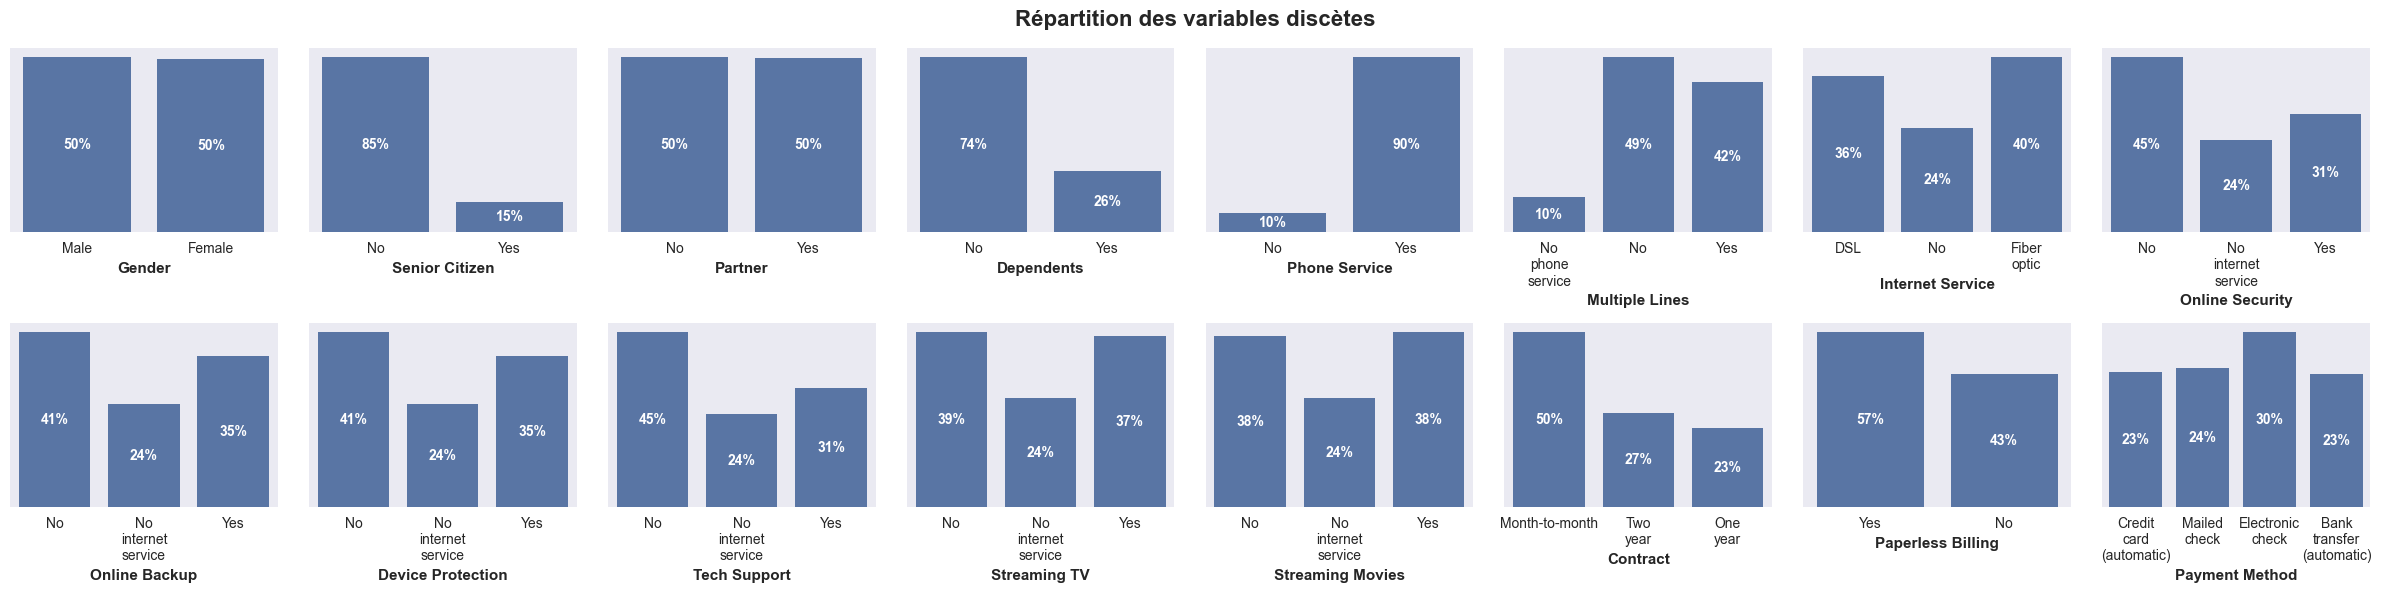

In [14]:
plot_disc_variables(df=df, cols=disc)

- Les répartitions hommes/femmes et avec/sans partenaire sont très équilibrées, tandis que les répartitions des personnes agées et des personnes ayant souscrit à un service de téléphone mobile sont déséquilibrées en faveur respecivement des personnes de moins de 65 ans (85%), et des personnes ayant souscrit à un service de téléphone mobile (90%).
- On peut également noter que le quart des clients ne vit pas avec des personnes à charge et la moitié renouvelle mensuellement son abonnement, tandis que l'autre moitié est presque équitablement répartie entre les personnes ayant souscrit à un abonnement annuel et les personnes ayant souscrit à un abonnement sur deux ans.
- La variable `Multiple Lines` est une version détaillée de `Phone Service`, on mesurera l'impact de la suppression de cette dernière de notre jeu de données.
- Aussi, nous remarquons que près du quart des clients de l'échantillon n'est pas abonné à un service Internet. En séparant les données suivant cette variable, ce dernier groupe pourra se passer des 6 variables qui donnent davantage de précisions sur lesdits services : `Online Security`, `Online Backup`, `Device Protection`, `Tech Support`, `Streaming TV` et `Streaming Movies`.

##### **1.1.a. Séparation avec/sans Internet**

In [15]:
df_internet = df[df["Internet Service"] != "No"].copy()
df_no_internet = df[df["Internet Service"] == "No"].copy()
disc_no_internet = ["Gender", "Senior Citizen", "Partner", "Dependents", "Phone Service", "Multiple Lines", "Contract", "Paperless Billing", "Payment Method"]

- Pour juger de la pertinence de ce split, nous évaluons le lien entre les autres variables (discrètes) et la variable cible à travers un test du chi-2.

In [16]:
from scipy.stats import chi2_contingency

tmp_dfs = {
    "Avec Internet": df_internet,
    "Sans Internet": df_no_internet,
}

for col in disc_no_internet:
    print(f" {col} ".center(25, "-"))
    for df_name, tmp_df in tmp_dfs.items():
        pvalue = chi2_contingency(pd.crosstab(tmp_df[col], tmp_df[target])).pvalue
        lien = " *" if pvalue < 0.05 else ""
        print(f"- {df_name}".ljust(15) + f"  {pvalue:.4f}" + lien)
    print()

--------- Gender --------
- Avec Internet  0.1254
- Sans Internet  0.8092

----- Senior Citizen ----
- Avec Internet  0.0000 *
- Sans Internet  0.7922

-------- Partner --------
- Avec Internet  0.0000 *
- Sans Internet  0.0022 *

------- Dependents ------
- Avec Internet  0.0000 *
- Sans Internet  0.0009 *

----- Phone Service -----
- Avec Internet  0.0008 *
- Sans Internet  1.0000

----- Multiple Lines ----
- Avec Internet  0.0024 *
- Sans Internet  0.0008 *

-------- Contract -------
- Avec Internet  0.0000 *
- Sans Internet  0.0000 *

--- Paperless Billing ---
- Avec Internet  0.0000 *
- Sans Internet  0.2546

----- Payment Method ----
- Avec Internet  0.0000 *
- Sans Internet  0.0022 *



- On observe qu'effectivement, selon que les clients aient souscrit ou non à un service Internet, le soutien à l'hypothèse d'indépendance entre les variables varie de manière significative. Les test ci-dessus suggèrent, avec un seuil fixé à 2%, des liens de dépendance suivants avec la variable cible :

| Colonnes | Avec Internet | Sans Internet |
|-|:-:|:-:|
| Gender            |   |   |
| Senior Citizen    | x |   |
| Partner           | x | x |
| Dependents        | x | x |
| Phone Service     | x |RAS|
| Multiple Lines    | x | x |
| Contract          | x | x |
| Paperless Billing | x |   |
| Payment Method    | x | x |

- Le fait qu'il existe des différences aussi notoires entre ces deux groupes nous conforte dans ce choix de séparer ainsi les données.
- **RAS → Aucune interprétation** : Les clients n'ayant souscrit à aucun service Internet sont forcément des abonnés mobile, on n'a donc qu'une seule modalité dans cette classe (Yes).
- Pour davantage comprendre, analysons visuellement ces relations.

In [17]:
def plot_disc_vs_target(df, segment, cols, figsize=(28, 4), fig_title_font_size=20):
    _, axes = plt.subplots(1, len(cols), figsize=figsize)
    
    for i, col in enumerate(cols):
        prop_df = pd.crosstab(df[col], df[target])
        prop_df = prop_df.div(prop_df.sum(axis=1), axis=0)
        
        ax = axes[i] if len(cols) > 1 else axes
        bar = prop_df.plot(kind="bar", stacked=True, legend=False, ax=ax)
        
        # Pourcentages
        for i, p in enumerate(bar.patches):
            if i < len(bar.patches) / 2:
                bar.text(
                    p.get_x() + p.get_width() / 2,
                    p.get_y() + p.get_height() / 2,
                    f"{p.get_height():.0%}",
                    ha="center", va="center",
                    c="w", weight="bold",
                )
                
        # Formatage des labels sur les axes
        bar.set_xlabel(col, weight="bold")
        bar.set_xticks(bar.get_xticks())
        
        xticklabels = ["\n".join(label.get_text().split()) for label in ax.get_xticklabels()]
        bar.set_xticklabels(xticklabels, rotation=0)
        
        bar.set_yticks([])
        bar.set_ylabel("")

    ax = axes[0] if len(cols) > 1 else axes
    ax.legend(title="Churn Value", bbox_to_anchor=(0, 1))
    
    plt.suptitle(f"Taux de churn, Segment = {segment}", size=fig_title_font_size, weight="bold")
    plt.tight_layout()
    plt.show()

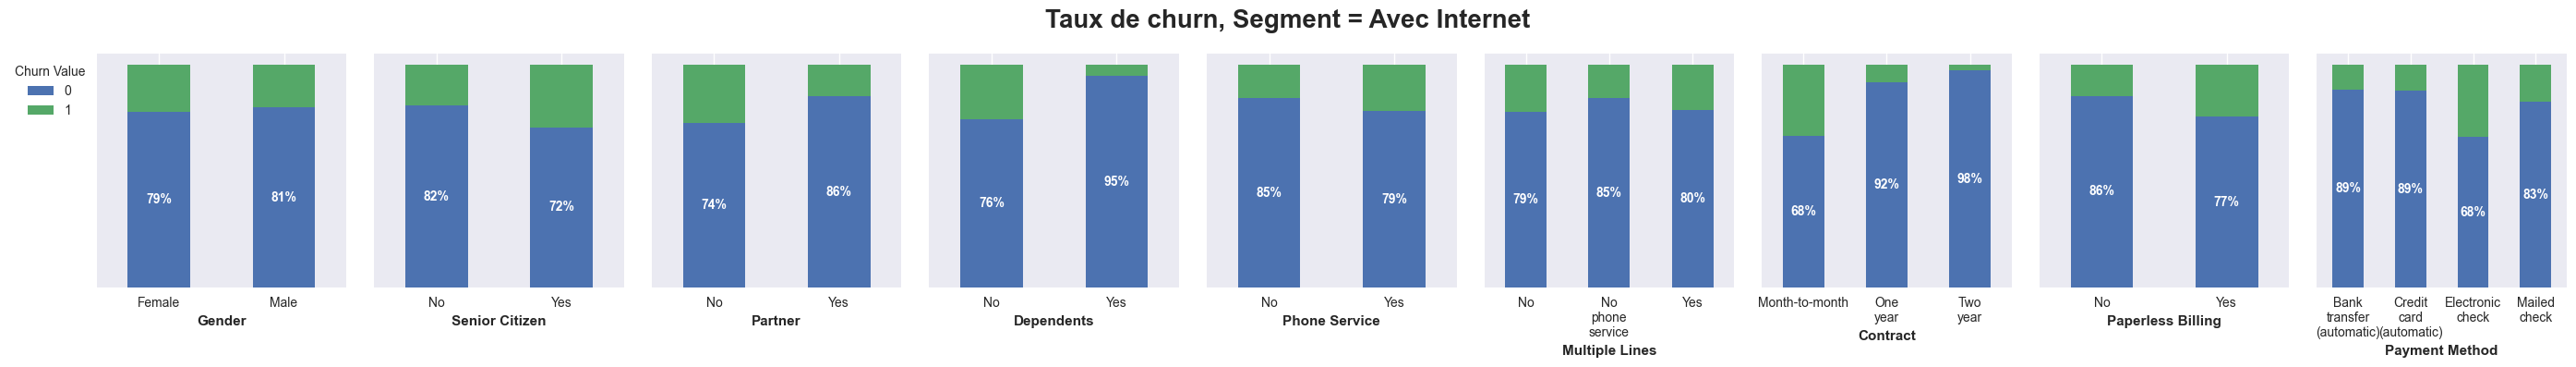

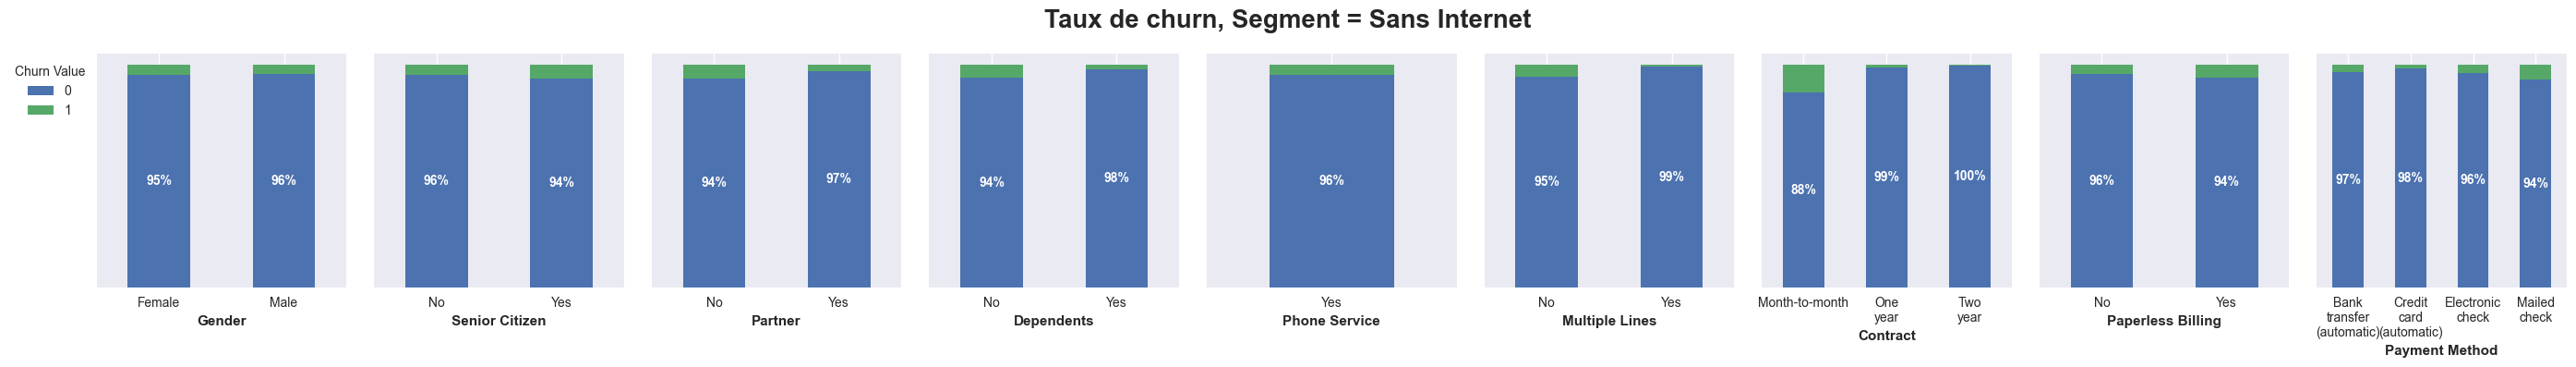

In [18]:
for segment, tmp_df in tmp_dfs.items():
    plot_disc_vs_target(df=tmp_df, segment=segment, cols=disc_no_internet)

In [19]:
print("Taux de churn :")
print(f"- Avec Internet : {df_internet[target].mean():.2%}")
print(f"- Sans Internet : {df_no_internet[target].mean():.2%}")

Taux de churn :
- Avec Internet : 19.94%
- Sans Internet : 4.44%


- Le premier constat est que la taux de churn est globalement plus élevé chez les clients ayant souscrit à des services Internet (20% vs. 4%).
- Précédemment, nous avons relevé des liens de dépendance entre certaines variables et la cible, nous pouvons dès lors apporter davantage de précisions.
- Pour l'ensemble des clients, nous remarquons que le taux de résiliation est plus élevé lorsque le client :
    - n'a pas de partenaire
    - n'a pas de personnes à charge
    - renouvelle mensuellement son contrat
    - ne possède qu'une seule ligne de téléphone
- Pour les cliens avec Internet, le taux de churn est plus élevé lorsque le client :
    - a plus de 65 ans
    - opte pour une facturation sans papier
    - règle ses factures par chèque électronique
- Pour ceux qui n'utilisent aucun service Internet, le churn est élevé lorsque le client :
    - règle ses factures via un chèque envoyé par courrier (impact relativement faible)
- Ceci nous aide à identifier ces variables, sauf peut-être le mode de règlement pour les clients sans Internet, comme des features importantes pour notre modèle.

##### **1.1.b. Analyse du lien entre les services Internet et la variable cible**

In [20]:
internet_services = ["Online Security", "Online Backup", "Device Protection", "Tech Support", "Streaming TV", "Streaming Movies"]

# Nombre de services auxquels le client a souscrit
df_internet["Services Count"] = df_internet[internet_services].replace({"No": "0", "Yes": "1"}).astype(int).sum(axis=1)
internet_services = ["Services Count"] + internet_services

# Test du chi-2 pour juger de l'indépendance entre les variables
for col in internet_services:
    print(f" {col} ".center(25, "-"))
    pvalue = chi2_contingency(pd.crosstab(df_internet[col], df_internet[target])).pvalue
    lien = " *" if pvalue < 0.05 else ""
    print(f"- Internet".ljust(15) + f"  {pvalue:.4f}" + lien)
    print()

----- Services Count ----
- Internet       0.0000 *

---- Online Security ----
- Internet       0.0000 *

----- Online Backup -----
- Internet       0.0000 *

--- Device Protection ---
- Internet       0.0000 *

------ Tech Support -----
- Internet       0.0000 *

------ Streaming TV -----
- Internet       0.0031 *

---- Streaming Movies ---
- Internet       0.1369



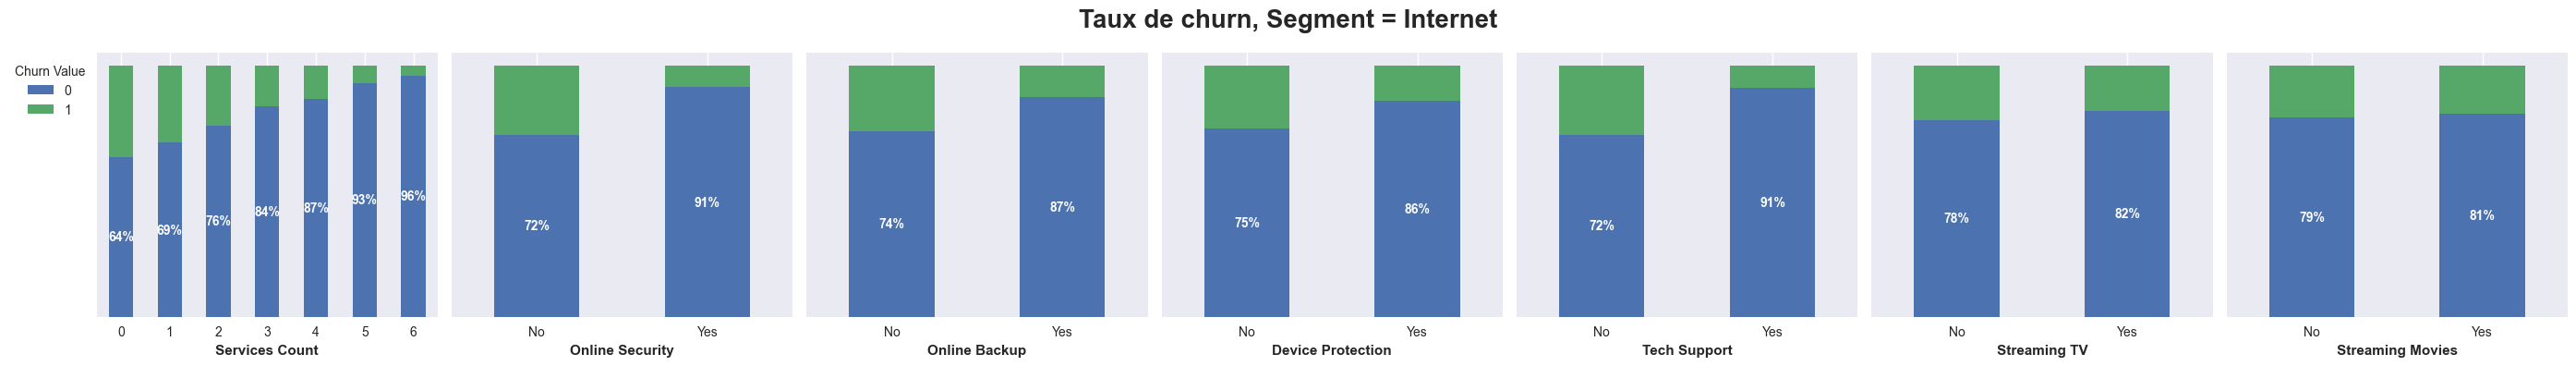

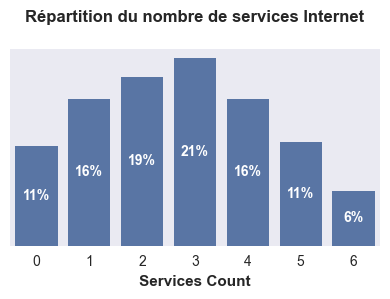

In [21]:
# Graphiques pour une meilleure interprétation des résultats
plot_disc_vs_target(df=df_internet, segment="Internet", cols=internet_services)
plot_disc_variables(df=df_internet, cols=["Services Count"], n_rows=1, n_cols=1, figsize=(4, 3), fig_title="Répartition du nombre de services Internet", fig_title_font_size=12)

- Il semblerait qu'il existe une relation de dépendance entre les différents services Internet et le taux de churn : plus le client souscrit à des options, plus on a de chances qu'il reste.
- Cette tendance est moins marquée pour les services liés au Streaming (TV et films). Sachant d'après le descriptif des données que l'entreprise ne facture pas de frais supplémentaires pour ce service, nous pouvons comprendre pourquoi ces services ne constituent pas un facteur différenciant dans la décion de rester ou de partir.
- Serait-il plus pertinent de ne conserver que le nombre de services consommés (hormis les services de streaming) étant donné la tendance observée ?

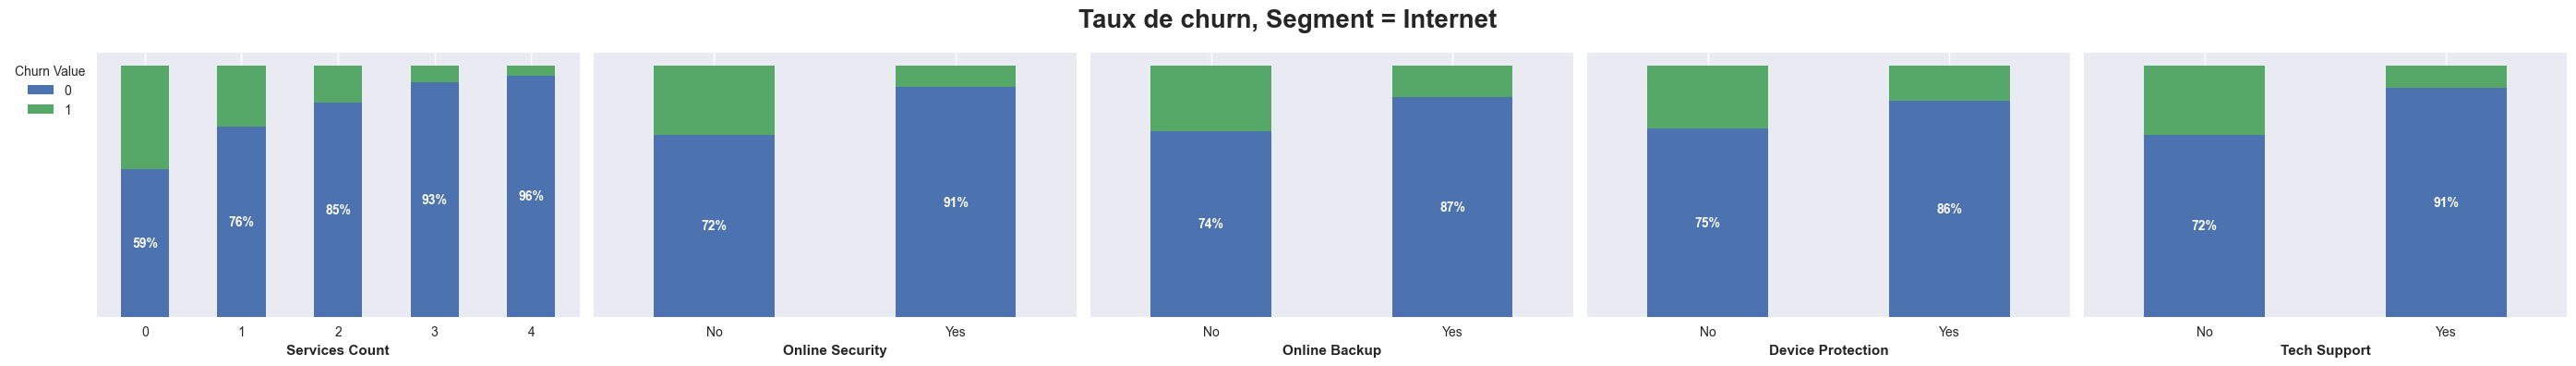

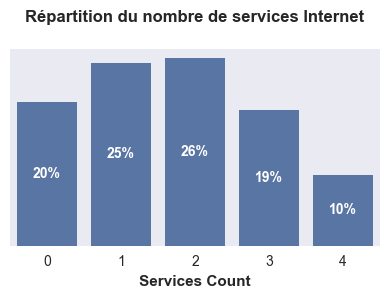

In [22]:
internet_services = ["Online Security", "Online Backup", "Device Protection", "Tech Support"]

# Nombre de services auxquels le client a souscrit
df_internet["Services Count"] = df_internet[internet_services].replace({"No": "0", "Yes": "1"}).astype(int).sum(axis=1)
internet_services = ["Services Count"] + internet_services

# Graphiques pour une meilleure interprétation des résultats
plot_disc_vs_target(df=df_internet, segment="Internet", cols=internet_services)
plot_disc_variables(df=df_internet, cols=["Services Count"], n_rows=1, n_cols=1, figsize=(4, 3), fig_title="Répartition du nombre de services Internet", fig_title_font_size=12)

- Les observations précédentes ne sont pas modifiées lorsque l'on supprime les colonnes liées au streaming, qu'il s'agisse de la relation décroissante entre le nombre de services et le taux de churn, ou alors de la répartition globale du nombre de services.

#### **1.2. Variables continues**

In [23]:
print(f"{len(cont)} variables continues : {cont}")

6 variables continues : ['Lat', 'Long', 'Monthly Charges', 'Total Charges', 'Tenure Months', 'CLTV']


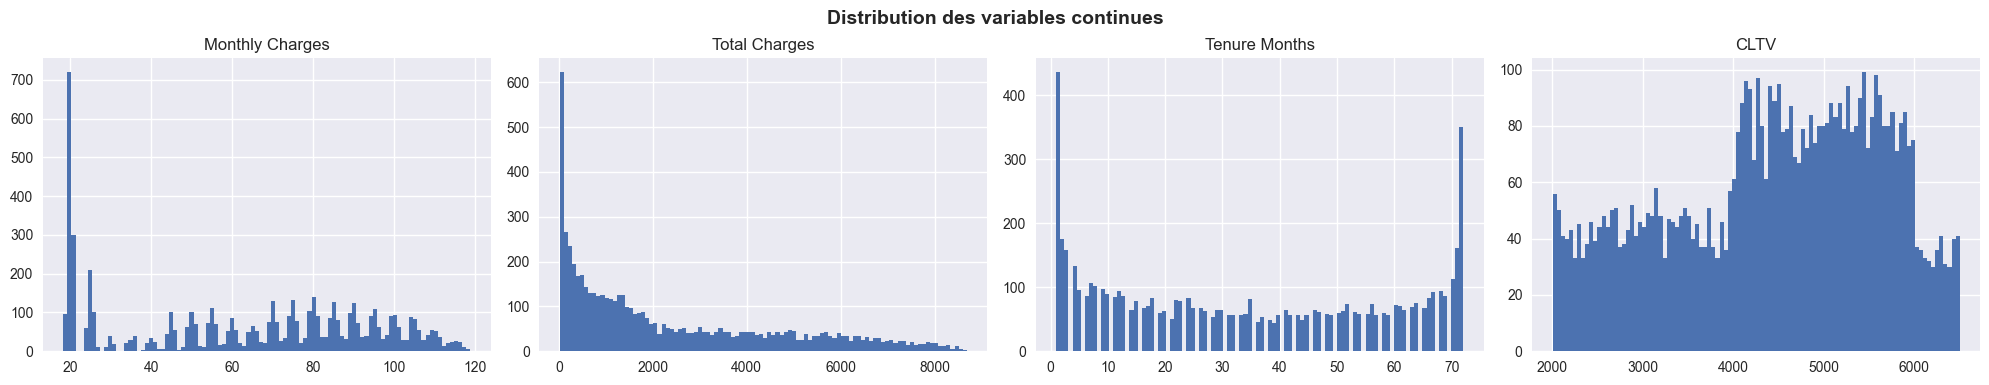

In [24]:
cols = ["Monthly Charges", "Total Charges", "Tenure Months", "CLTV"]
df.hist(column=cols, figsize=(20, 4), layout=(1, 4), bins=100)

plt.suptitle("Distribution des variables continues", y=0.95, size=14, weight="bold")
plt.tight_layout()
plt.show()

- Charges mensuelles
    - La plupart des clients dépensent mensuellement entre 20 et 30.
    - On observe ensuite deux potentiels signaux de distributions, l'une pour les valeurs allant de 30 à 65, et l'autre pour les valeurs entre 65 et 120. 
    - Serait-ce lié au type de contrat (mensuel, annuel, biennal) et/ou au nombre de produits consommés ?

- Charges totales
    - 

- Ancienneté
    -

- Valeur vie client
    - 

In [25]:
# df.drop(columns="Phone Service", )

In [26]:
# df.loc[df["Contract"] == "Two year"].sort_values("Tenure Months")[["Tenure Months", target]]["Churn Value"].value_counts().plot(kind="bar")

In [27]:
# df.loc[df["Contract"] == "Two year"].sort_values("Tenure Months")[["Tenure Months", target]].loc[df["Churn Value"] == 1]

In [28]:
# # Create an ID for each unique value of Senior-Partner-Dependant
# df["Senior-Partner-Dependents"] = df["Senior Citizen"].astype(int).astype(str) + df["Partner"].astype(int).astype(str) + df["Dependents"].astype(int).astype(str)

In [29]:
# df.iloc[:, 7:16].columns

In [30]:
# sns.displot(data=df, x="Monthly Charges", hue="Contract", kind="kde")